In [75]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pprint
import random
from sklearn.metrics import silhouette_score, davies_bouldin_score, v_measure_score
from sklearn.preprocessing import MinMaxScaler

# ignore warnings
import warnings
warnings.filterwarnings('ignore')



In [76]:
dataset = pd.read_csv("diagnosed_cbc_data_v4.csv")
# dataset.head()

In [77]:
unique_targets = set(dataset['Diagnosis'])
pprint.pprint(unique_targets)
print("Quantidade de classes únicas -> ", len(unique_targets))

{'Healthy',
 'Iron deficiency anemia',
 'Leukemia',
 'Leukemia with thrombocytopenia',
 'Macrocytic anemia',
 'Normocytic hypochromic anemia',
 'Normocytic normochromic anemia',
 'Other microcytic anemia',
 'Thrombocytopenia'}
Quantidade de classes únicas ->  9


In [78]:
for col in dataset.columns:
    try:
        if dataset[col].min() < 0:
            print(col)
    except:
        pass

HGB
MCV


In [79]:
dataset = dataset.drop(dataset[dataset['HGB'] < 0].index[0])
dataset = dataset.drop(dataset[dataset['MCV'] < 0].index[0])

In [80]:
print("Duplicações antes da exclusão: ", dataset.duplicated().sum())
dataset.drop_duplicates(inplace=True)
print("Duplicações após exclusão: ", dataset.duplicated().sum())

Duplicações antes da exclusão:  49
Duplicações após exclusão:  0


In [81]:
dataset = dataset.drop('Diagnosis', axis=1)

In [82]:
def euclidean_distance(point1, point2):
    return sum((p1 - p2) ** 2 for p1, p2 in zip(point1, point2)) ** 0.5

In [84]:
def kmeans(df, k, max_iterations=10): 
    points = df.values.tolist()
    centroids = random.sample(points, k)
    
    for _ in range(max_iterations):
        # Calcular as distâncias entre cada ponto e os centróides
        labels = []
        for point in points:
            distances = [euclidean_distance(point, centroid) for centroid in centroids]
            labels.append(distances.index(min(distances)))
        
        new_centroids = []
        for i in range(k):
            cluster_points = [point for point, label in zip(points, labels) if label == i]
            if cluster_points:
                new_centroid = [sum(dim) / len(cluster_points) for dim in zip(*cluster_points)]
            else:
                new_centroid = centroids[i]
            new_centroids.append(new_centroid)
        
        if new_centroids == centroids:
            break
        
        centroids = new_centroids
    
    return centroids, labels

In [85]:
def predict(new_points, centroids):
    predictions = []
    for point in new_points:
        distances = [euclidean_distance(point, centroid) for centroid in centroids]
        predictions.append(distances.index(min(distances)))
    return predictions

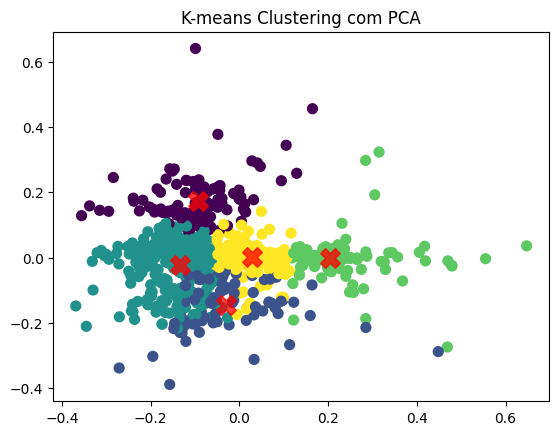

In [86]:
mm = MinMaxScaler()
df_to_kmeans=mm.fit_transform(dataset)
dataset = pd.DataFrame(df_to_kmeans,columns=dataset.columns )

k = 5
centroids, labels = kmeans(dataset, k)
y_kmeans = predict(dataset.values.tolist(), centroids)

pca = PCA(n_components=2)
df_pca = pca.fit_transform(dataset)
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = pca.transform(centroids)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='X')
# plt.xlabel('Componente 1')
# plt.ylabel('Componene 2')
plt.title('K-means Clustering com PCA')
plt.show()

O coeficiente de Silhouette mede o quão similar um ponto é ao seu próprio cluster em comparação com outros clusters.

In [87]:
coeficiente_silhueta = silhouette_score(dataset, labels)
davies_bouldin = davies_bouldin_score(dataset, labels)
v_measure = v_measure_score(labels, y_kmeans)
print("coeficiente de silhouete >> ", coeficiente_silhueta)
print("davies_bouldin >> ", davies_bouldin)
print("v_measure >> ", v_measure)

coeficiente de silhouete >>  0.2825402776987906
davies_bouldin >>  1.2013967298901076
v_measure >>  1.0


Referências
- https://geeksforgeeks.org/clustering-metrics/
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans